### Data Management

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from scipy import stats
from geopy import distance
import geopy
import datetime as dt
from numpy import array 
from numpy import argmax 
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# show all columns of dataframe
pd.set_option('display.max_columns', 30)

In [3]:
# import datasets
df_train = pd.read_csv('fraudTrain.csv', parse_dates = ['trans_date_trans_time'])
df_test = pd.read_csv('fraudTest.csv', parse_dates = ['trans_date_trans_time'])

# combine training and testing sets together
df = pd.concat([df_train, df_test], ignore_index = True)
# remove first column as we don't need two index columns
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [4]:
# get the number of observations and attributes
print(df.shape)

(1852394, 22)


There are 1,852,394 observations and 22 attributes.

**Data Cleaning**

In [5]:
# check dataset for null values
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

There are no null values in the dataset.

In [6]:
df[df.duplicated()]

Empty DataFrame
Columns: [trans_date_trans_time, cc_num, merchant, category, amt, first, last, gender, street, city, state, zip, lat, long, city_pop, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud]
Index: []

There are no duplicate entries.

In [7]:
df.dtypes.value_counts()

object            11
int64              5
float64            5
datetime64[ns]     1
dtype: int64

The attributes are not all numerical; there are 12 categorical attributes that should be encoded.
- Transaction Date and Time (`trans_date_trans_time`)
- Merchant (`merchant`)
- Category (`category`)
- First Name (`first`)
- Last Name (`last`)
- Gender (`gender`)
- Street (`street`)
- City (`city`)
- State (`state`)
- Job (`job`)
- Date of Birth (`dob`)
- Transaction Number (`trans_num`)

**Outliers**

In [8]:
df.describe()

cc_num           amt           zip           lat          long  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.173860e+17  7.006357e+01  4.881326e+04  3.853931e+01 -9.022783e+01   
std    1.309115e+18  1.592540e+02  2.688185e+04  5.071470e+00  1.374789e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.640000e+00  2.623700e+04  3.466890e+01 -9.679800e+01   
50%    3.521417e+15  4.745000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.310000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.992100e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  
mean   8.864367e+04  1.358674e+09  3.853898e+01 -9.022794e+01  5.210015e-03  
std    3.014876e+05  1.819508e+07  5.105604e+00  1.375969e+01  7.199217e-02  
min    2.300000e+01  1.325376e+09  1.902742e+01 -1.666716e+02  0.000000e+00  
25%    7.410000e+02  1.343017e+09  3.474012e+01 -9.689944e+01  0.000000e+00  
50%    2.443000e+03  1.357089e+09  3.936890e+01 -8.744069e+01  0.000000e+00  
75%    2.032800e+04  1.374581e+09  4.195626e+01 -8.024511e+01  0.000000e+00  
max    2.906700e+06  1.388534e+09  6.751027e+01 -6.695090e+01  1.000000e+00

The only column that appears to have outliers is the `amt` column. There is a big difference between 75% and the max.

We use a 99.9% quantile as it seems to have the biggest jump from the rest of the data.

In [9]:
df['amt'].quantile(.999)

1517.2410500000465

In [10]:
max_threshold = df['amt'].quantile(.999)
df[df['amt'] > max_threshold]

trans_date_trans_time            cc_num  \
511       2019-01-01 06:43:54  4509142395811241   
1784      2019-01-01 18:51:15   341546199006537   
5418      2019-01-04 13:19:04  3500165543009955   
5546      2019-01-04 14:57:38      630451534402   
5627      2019-01-04 16:04:51  3589255887819806   
...                       ...               ...   
1849037   2020-12-31 00:08:32   372246459334925   
1850612   2020-12-31 13:42:39    30596478689301   
1851016   2020-12-31 16:06:57  3536818734263520   
1851201   2020-12-31 17:06:52  6528911529051375   
1851679   2020-12-31 19:43:11  4364010865167176   

                                     merchant      category      amt  \
511                   fraud_McGlynn-Heathcote      misc_net  1636.87   
1784                        fraud_Boyer-Haley        travel  3178.51   
5418                    fraud_Breitenberg LLC        travel  1703.76   
5546                    fraud_Turner and Sons  shopping_pos  1618.22   
5627                 fraud_Stoltenberg-Beatty  shopping_pos  2753.89   
...                                       ...           ...      ...   
1849037            fraud_Jaskolski-Vandervort      misc_net  2045.37   
1850612                fraud_Hermann and Sons  shopping_pos  2416.72   
1851016   fraud_Heathcote, Yost and Kertzmann  shopping_net  1540.15   
1851201  fraud_Schroeder, Wolff and Hermiston        travel  3304.44   
1851679   fraud_Douglas, Schneider and Turner  shopping_pos  2149.66   

            first      last gender                        street        city  \
511      Margaret  Williams      F   165 Jerry Meadows Suite 460    Surrency   
1784         Mark     Brown      M               8580 Moore Cove       Wales   
5418        Ricky      Dunn      M    97689 Davis Point Apt. 967     Detroit   
5546       Rachel   Daniels      F     561 Little Plain Apt. 738     Wetmore   
5627        David    Miller      M    622 Bradley Knoll Apt. 758     Hancock   
...           ...       ...    ...                           ...         ...   
1849037      Rick  Martinez      M     062 Poole Hollow Apt. 815    Deadwood   
1850612    Daniel    Graham      M    28223 Ward Summit Apt. 664      Arvada   
1851016    Gerald     Frank      M  95793 Andrea Ville Suite 533  Des Moines   
1851201     Diane     Smith      F  195 Murray Overpass Apt. 384      Winter   
1851679      Gary  Martinez      M           03512 Jackson Ports        Reno   

        state    zip      lat      long  city_pop  \
511        GA  31563  31.6489  -82.1982      1324   
1784       AK  99783  64.7556 -165.6723       145   
5418       MI  48214  42.3669  -82.9938    673342   
5546       MI  49895  46.3535  -86.6345       765   
5627       MD  21750  39.6991  -78.1762      3766   
...       ...    ...      ...       ...       ...   
1849037    SD  57732  44.3566 -103.6999      1979   
1850612    CO  80005  39.8422 -105.1097    122111   
1851016    IA  50314  41.6030  -93.6330    222785   
1851201    WI  54896  45.8327  -91.0144      1478   
1851679    NV  89512  39.5483 -119.7957    276896   

                                   job         dob  \
511          Engineer, technical sales  1926-07-12   
1784          Administrator, education  1939-11-09   
5418                    Health visitor  1983-09-02   
5546                      Immunologist  1972-06-12   
5627                Press photographer  1984-02-14   
...                                ...         ...   
1849037          Multimedia programmer  1970-03-13   
1850612                  Hotel manager  1987-05-23   
1851016  Interior and spatial designer  1981-08-10   
1851201                   Neurosurgeon  1965-04-27   
1851679                   Immunologist  1997-03-12   

                                trans_num   unix_time  merch_lat  merch_long  \
511      9b13fb1ce565b55afe4106ecdee9346b  1325400234  31.608415  -83.145823   
1784     7083124580d6a391d678fb76b67a1ebb  1325443875  64.396477 -165.209648   
5418     aae2814cc22f39b426f22d39b3e60b11  

In [11]:
df['amt'].quantile(.01)

1.26

For the lower half, there doesn't seem to be any outliers. The data seems to decrease consistently.

<AxesSubplot:xlabel='amt'>

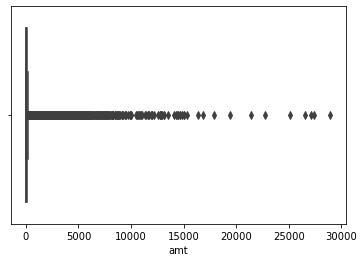

In [12]:
# boxplot for amount attribute
sns.boxplot(x = df['amt'])

In [13]:
# check whether the outlier cases are fraudulent cases or not
df[df['amt'] > 20000].is_fraud

352894     0
606211     0
787549     0
793677     0
1234797    0
1813708    0
1831344    0
Name: is_fraud, dtype: int64

Since the outliers are nonfraudulent cases and seem to be valid, we will not remove them.

**Add Features Using Given Attributes**

In [14]:
# hour a transaction was made

df['hour'] = 0
df.loc[df.trans_date_trans_time.dt.hour < 7, 'hour'] = 1
df.loc[df.trans_date_trans_time.dt.hour > 22, 'hour'] = 1

We will add an attribute called `hour` which is the hour a transaction was made. We encode transactions made between 7am and 10pm as 0 and transactions made between 10pm and 7am as 1.

In [15]:
# distance in miles between merchant latitude/longitude and card owner's latitude/longitude
# took about 6.5 minutes to finish running

def calcDistance(coord1_lat, coord1_long, coord2_lat, coord2_long):
    coordinate1 = geopy.Point(coord1_lat, coord1_long)
    coordinate2 = geopy.Point(coord2_lat, coord2_long)
    return distance.distance(coordinate1, coordinate2).miles

df['dist'] = df.apply(lambda x: calcDistance(x['lat'], x['long'], x['merch_lat'], x['merch_long']), axis=1)

We will add an attribute called `dist` which is the distance in miles between the merchant's latitude and longitude (where the transaction was made) and the card owner's address's latitude and longitude.

In [16]:
# code from https://www.kaggle.com/kartik2112/credit-card-transactions-fraud-detection-eda
# number of transactions made within last 7 days

def last7DaysTransactionCount(obs):
    # set index to be transaction date/time in order to group by card number and 7 day windows
    temp = pd.Series(obs.index, index = obs.trans_date_trans_time, name='trans_count_7d').sort_index()
    trans_count_7d = temp.rolling('7d').count() - 1
    trans_count_7d.index = temp.values
    obs['trans_count_7d'] = trans_count_7d.reindex(obs.index)
    return obs

df = df.groupby('cc_num').apply(last7DaysTransactionCount)

# number of transactions made within last 30 days

def last30DaysTransactionCount(obs):
    temp = pd.Series(obs.index, index = obs.trans_date_trans_time, name='trans_count_30d').sort_index()
    trans_count_30d = temp.rolling('30d').count() - 1
    trans_count_30d.index = temp.values
    obs['trans_count_30d'] = trans_count_30d.reindex(obs.index)
    return obs

df = df.groupby('cc_num').apply(last30DaysTransactionCount)

We will add two attributes called `trans_count_7d` and `trans_count_30d`. These attributes are the number of transactions made by a card within the last 7 days and the last 30 days.

In [17]:
# code from https://www.kaggle.com/kartik2112/credit-card-transactions-fraud-detection-eda
# time (hours) since last transaction

def timeDiff(cc_num):
    cc_num['time_diff'] = cc_num.trans_date_trans_time - cc_num.trans_date_trans_time.shift()
    return cc_num

temp = df.groupby('cc_num').apply(timeDiff)
df['time_diff'] = (temp['time_diff'].dt.seconds)/3600
df.loc[df.time_diff.isna(), 'time_diff'] = 0

We will add an attribute called `time_diff` which is the time in hours since the last transaction was made on a card.

In [18]:
df.head()

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city state    zip      lat  \
0                561 Perry Cove  Moravian Falls    NC  28654  36.0788   
1  43039 Riley Greens Suite 393          Orient    WA  99160  48.8878   
2      594 White Dale Suite 530      Malad City    ID  83252  42.1808   
3   9443 Cynthia Court Apt. 038         Boulder    MT  59632  46.2306   
4              408 Bradley Rest        Doe Hill    VA  24433  38.4207   

       long  city_pop                                job         dob  \
0  -81.1781      3495          Psychologist, counselling  1988-03-09   
1 -118.2105       149  Special educational needs teacher  1978-06-21   
2 -112.2620      4154        Nature conservation officer  1962-01-19   
3 -112.1138      1939                    Patent attorney  1967-01-12   
4  -79.4629        99     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

   is_fraud  hour       dist  trans_count_7d  trans_count_30d  time_diff  
0         0     1  48.947783             0.0              0.0        0.0  
1         0     1  18.775736             0.0              0.0        0.0  
2         0     1  67.172035             0.0              0.0        0.0  
3         0     1  59.455974             0.0              0.0        0.0  
4         0     1  48.282030             0.0              0.0        0.0

**Data Preprocessing**

In [19]:
# label encoding

encoder = LabelEncoder()

gender = array(df['gender'])
job = array(df['job'])
category = array(df['category'])
merchant = array(df['merchant'])
city = array(df['city'])
state = array(df['state'])

gender_label = pd.DataFrame(encoder.fit_transform(gender))
gender_label.set_axis(['gender'], axis = 1, inplace = True)
job_label = pd.DataFrame(encoder.fit_transform(job))
job_label.set_axis(['job'], axis = 1, inplace = True)
category_label = pd.DataFrame(encoder.fit_transform(category))
category_label.set_axis(['category'], axis = 1, inplace = True)
merchant_label = pd.DataFrame(encoder.fit_transform(merchant))
merchant_label.set_axis(['merchant'], axis = 1, inplace = True)
city_label = pd.DataFrame(encoder.fit_transform(city))
city_label.set_axis(['city'], axis = 1, inplace = True)
state_label = pd.DataFrame(encoder.fit_transform(state))
state_label.set_axis(['state'], axis = 1, inplace = True)

Since the categorical variables are nominal and not ordinal, label encoding is probably not appropriate in this case.

In [20]:
# one-hot encoding

onehot_encoder = OneHotEncoder(sparse = False)

# gender
encoded = encoder.fit_transform(gender)
encoded = encoded.reshape(len(encoded), 1)
gender_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
gender_onehot.columns = onehot_encoder.get_feature_names(['gender'])

# job
encoded = encoder.fit_transform(job)
encoded = encoded.reshape(len(encoded), 1)
job_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
job_onehot.columns = onehot_encoder.get_feature_names(['job'])

# category
encoded = encoder.fit_transform(category)
encoded = encoded.reshape(len(encoded), 1)
category_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
category_onehot.columns = onehot_encoder.get_feature_names(['category'])

# merchant
encoded = encoder.fit_transform(merchant)
encoded = encoded.reshape(len(encoded), 1)
merchant_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
merchant_onehot.columns = onehot_encoder.get_feature_names(['merchant'])

# city
encoded = encoder.fit_transform(city)
encoded = encoded.reshape(len(encoded), 1)
city_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
city_onehot.columns = onehot_encoder.get_feature_names(['city'])

# state
encoded = encoder.fit_transform(state)
encoded = encoded.reshape(len(encoded), 1)
state_onehot = pd.DataFrame(onehot_encoder.fit_transform(encoded))
state_onehot.columns = onehot_encoder.get_feature_names(['state'])

We encoded the categorical variables: `gender`, `job`, `category`, `merchant`, `city`, and `state`. We did not encode `trans_date_trans_time`, `first`, `last`, `street`, `dob`, and `trans_num` as these variables did not seem useful for our model.

**Exploratory Data Analysis**

Total number of observations: 1852394
Number of non-fraud cases: 1842743
Number of fraud cases: 9651
Percentage of non-fraud cases: 99.479
Percentage of fraud cases: 0.521


<AxesSubplot:title={'center':'Number of Fraud Occurrences'}, xlabel='Fraud', ylabel='Count (millions)'>

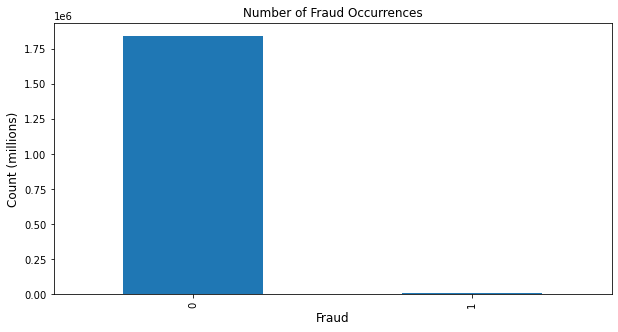

In [21]:
observations = len(df)

non_fraud_count = len(df[df.is_fraud == 0])
fraud_count = len(df[df.is_fraud == 1])

non_fraud_percentage = round(non_fraud_count/observations * 100, 4)
fraud_percentage = round(fraud_count/observations * 100, 4)

print('Total number of observations:', observations)
print('Number of non-fraud cases:', non_fraud_count)
print('Number of fraud cases:', fraud_count)
print('Percentage of non-fraud cases:', non_fraud_percentage)
print('Percentage of fraud cases:', fraud_percentage)

plt.figure(figsize = (10, 5))
plt.xlabel('Fraud', fontsize = 12)
plt.ylabel('Count (millions)', fontsize = 12)
plt.title('Number of Fraud Occurrences')
df['is_fraud'].value_counts().plot.bar()

The dataset is unbalanced as there are more non-fraud cases than fraud cases. In this case, we should use a different metric like precision instead of accuracy.

is_fraud                                0     1      All
merchant                                                
fraud_Abbott-Rogahn                  2643     4     2647
fraud_Abbott-Steuber                 2521     8     2529
fraud_Abernathy and Sons             2509     4     2513
fraud_Abshire PLC                    2724     9     2733
fraud_Adams, Kovacek and Kuhlman     1349     5     1354
...                                   ...   ...      ...
fraud_Zemlak, Tillman and Cremin     2535     3     2538
fraud_Ziemann-Waters                 2428    10     2438
fraud_Zieme, Bode and Dooley         3710    10     3720
fraud_Zulauf LLC                     2601     4     2605
All                               1842743  9651  1852394

[694 rows x 3 columns]

is_fraud                         0     1      All
city                                             
Achille                        727    13      740
Acworth                       2912    13     2925
Adams                          727    12      739
Afton                         2916    16     2932
Akron                          724     9      733
...                            ...   ...      ...
Woodville                     2912    10     2922
Yellowstone National Park      730    12      742
Zaleski                       2183    12     2195
Zavalla                       2186    12     2198
All                        1842743  9651  1852394

[907 rows x 3 columns]

is_fraud        0     1      All
zip                             
1257         2914     9     2923
1330         1457     9     1466
1535          725     9      734
1545         1459     9     1468
1612          729     9      738
...           ...   ...      ...
99746         725     9      734
99747           0    12       12
99783        2188    15     2203
99921           0    14       14
All       1842743  9651  1852394

[986 rows x 3 columns]

is_fraud                                    0     1      All
job                                                         
Academic librarian                       1456    11     1467
Accountant, chartered                       0    11       11
Accountant, chartered certified           730    21      751
Accountant, chartered public finance     3648     9     3657
Accounting technician                    6562    33     6595
...                                       ...   ...      ...
Water quality scientist                   727     7      734
Web designer                             3644    18     3662
Wellsite geologist                       3637    32     3669
Writer                                    726    15      741
All                                   1842743  9651  1852394

[498 rows x 3 columns]

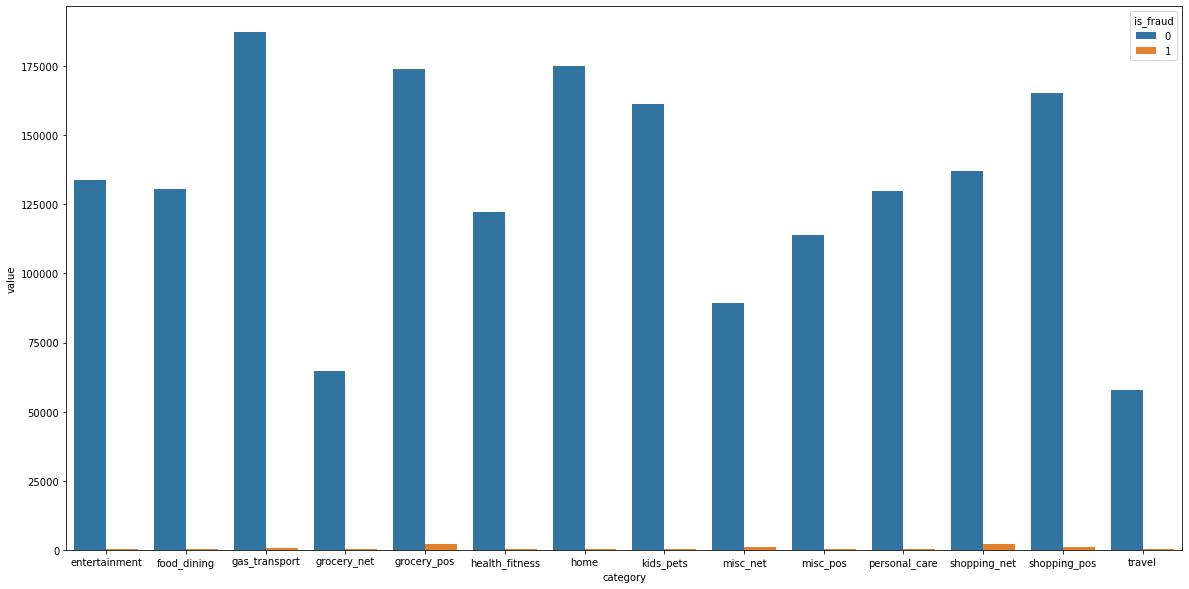

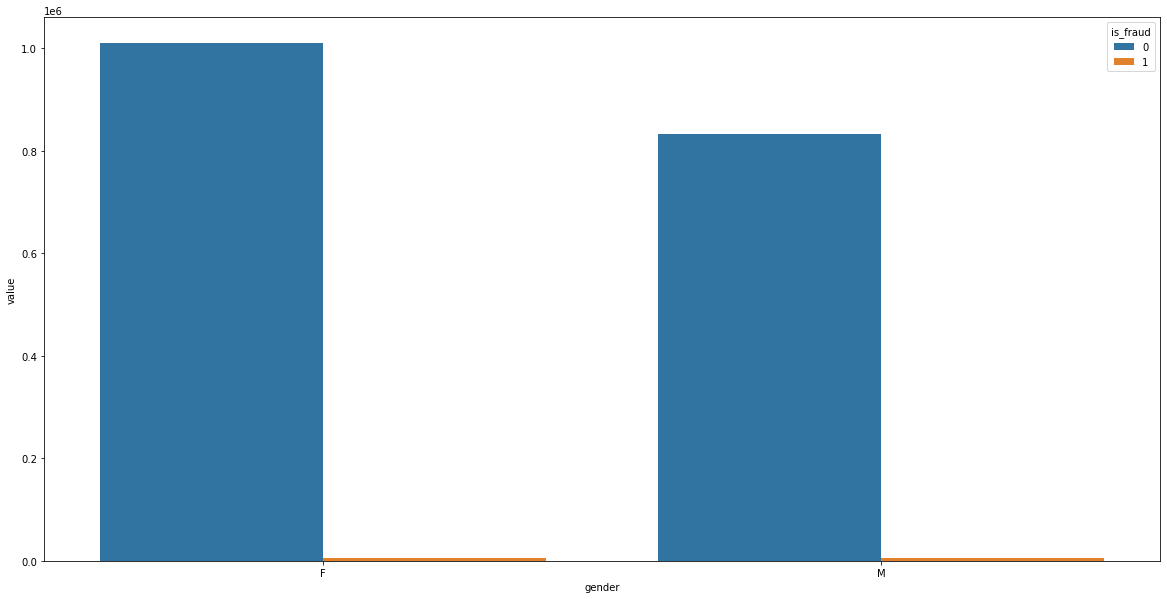

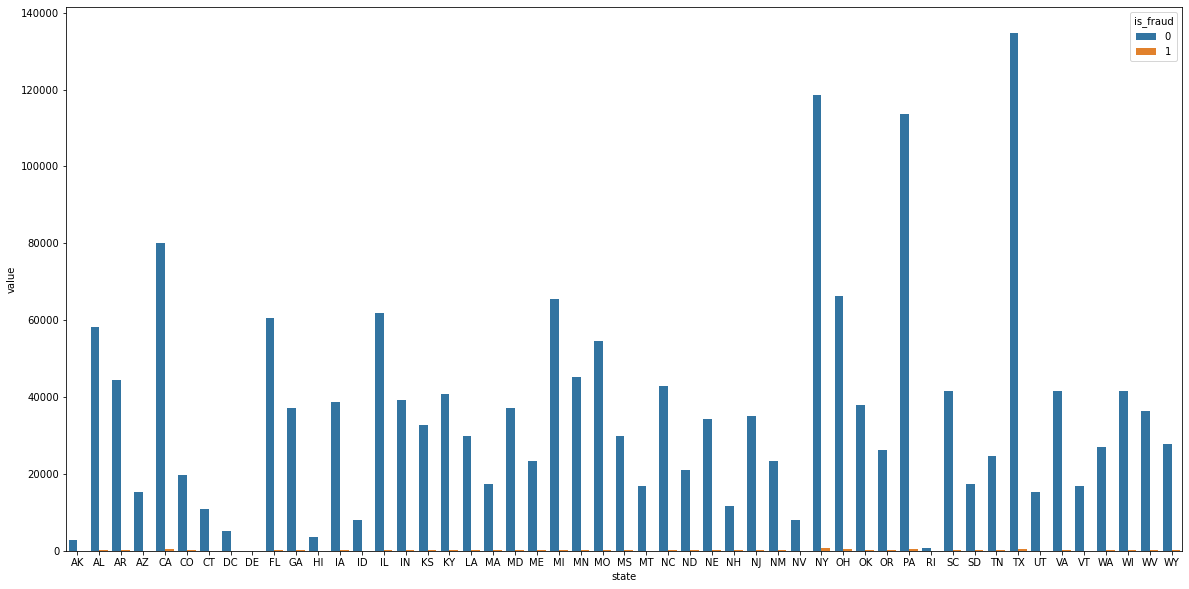

In [22]:
# contingency tables and plots

display(pd.crosstab(df['merchant'], df['is_fraud'], margins = True))
    
plt.figure(figsize = (20, 10))
ct = pd.crosstab(df['category'], df['is_fraud'])
stacked = ct.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x = stacked.category, y = stacked.value, hue = stacked.is_fraud)

plt.figure(figsize = (20, 10))
ct = pd.crosstab(df['gender'], df['is_fraud'])
stacked = ct.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x = stacked.gender, y = stacked.value, hue = stacked.is_fraud)

display(pd.crosstab(df['city'], df['is_fraud'], margins = True))

plt.figure(figsize = (20, 10))
ct = pd.crosstab(df['state'], df['is_fraud'])
stacked = ct.stack().reset_index().rename(columns={0:'value'})
sns.barplot(x = stacked.state, y = stacked.value, hue = stacked.is_fraud)

display(pd.crosstab(df['zip'], df['is_fraud'], margins = True))
display(pd.crosstab(df['job'], df['is_fraud'], margins = True))

From the contigency tables and plots above, we can see that:  
- The highest number of transactions are in the `gas_transport` category and the highest number of fraudulent transactions are in the `grocery_pos` category.  
- The highest number of transactions came from Texas `(TX)` and the highest number of fraudulent transactions came from New York `(NY)`.
- `Females` made up more of both the total number of transactions and also the total number of fraudulent transactions.
- The `Film/video editor` job had the highest number of transactions and the `Quantity surveyor` job had the highest number of fraudulent transactions.
- The city with the highest number of transactions is `Birmingham` and the city with the highest number of fraudulent transactions is `Dallas`.
- The zip code with the highest number of transactions is `73754` and the zip code with the highest number of fraudulent transactions is `15010`.
- The merchant with both the highest number of transactions and highest number of fraudulent transactions is `Kilback LLC`.

We did not make plots for the `merchant`, `city`, `job`, or `zip` attributes because they have too many unique values.

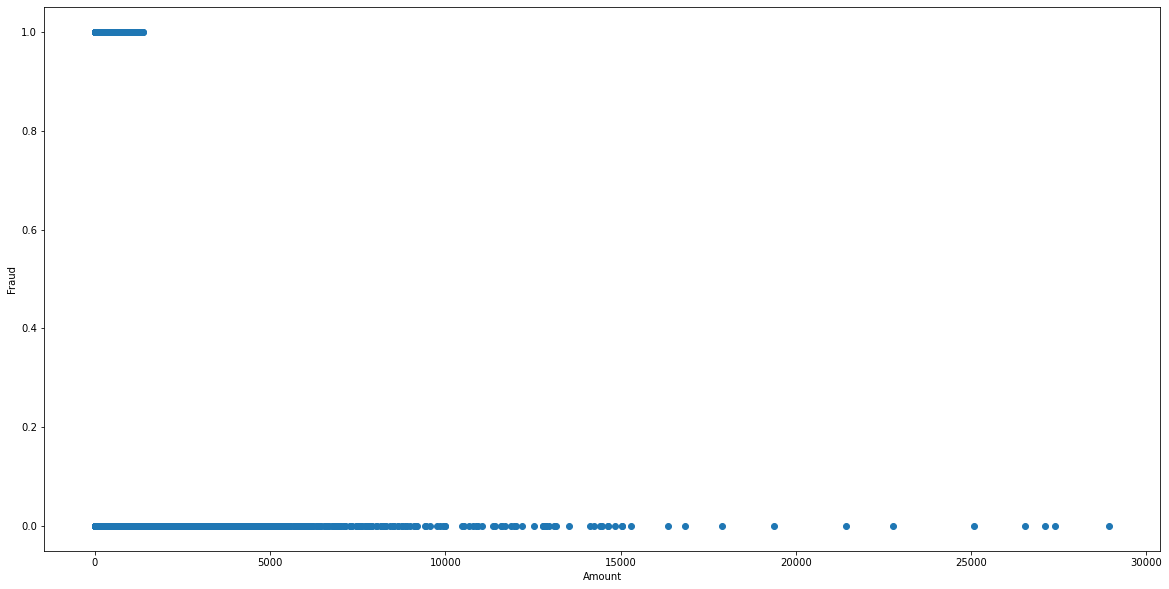

In [23]:
# scatterplot for amount attribute

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(df['amt'], df['is_fraud'])
ax.set_xlabel('Amount')
ax.set_ylabel('Fraud')
plt.show()

From the plot above, we can see that for fraudulent cases, the amount spent in a transaction is always less than $2000.

In [24]:
nonfraud = df[df['is_fraud'] == 0]
fraud = df[df['is_fraud'] == 1]

display(pd.concat([nonfraud['amt'].describe(), fraud['amt'].describe()], axis = 1))
display(pd.concat([nonfraud['hour'].describe(), fraud['hour'].describe()], axis = 1))
display(pd.concat([nonfraud['trans_count_30d'].describe(), fraud['trans_count_30d'].describe()], axis = 1))
display(pd.concat([nonfraud['trans_count_7d'].describe(), fraud['trans_count_7d'].describe()], axis = 1))
display(pd.concat([nonfraud['time_diff'].describe(), fraud['time_diff'].describe()], axis = 1))

amt          amt
count  1.842743e+06  9651.000000
mean   6.765128e+01   530.661412
std    1.535481e+02   391.028873
min    1.000000e+00     1.060000
25%    9.610000e+00   240.075000
50%    4.724000e+01   390.000000
75%    8.256000e+01   902.365000
max    2.894890e+04  1376.040000

hour         hour
count  1.842743e+06  9651.000000
mean   2.790405e-01     0.609574
std    4.485276e-01     0.487871
min    0.000000e+00     0.000000
25%    0.000000e+00     0.000000
50%    0.000000e+00     1.000000
75%    1.000000e+00     1.000000
max    1.000000e+00     1.000000

trans_count_30d  trans_count_30d
count     1.842743e+06      9651.000000
mean      1.082988e+02        74.263289
std       5.449353e+01        51.449693
min       0.000000e+00         0.000000
25%       6.900000e+01        35.000000
50%       1.030000e+02        64.000000
75%       1.410000e+02       105.000000
max       3.880000e+02       322.000000

trans_count_7d  trans_count_7d
count    1.842743e+06     9651.000000
mean     2.653186e+01       19.281629
std      1.478014e+01       11.827747
min      0.000000e+00        0.000000
25%      1.600000e+01       11.000000
50%      2.400000e+01       17.000000
75%      3.500000e+01       26.000000
max      1.090000e+02       91.000000

time_diff    time_diff
count  1.842743e+06  9651.000000
mean   6.054043e+00     4.853261
std    5.811174e+00     6.654018
min    0.000000e+00     0.000000
25%    1.509444e+00     0.389583
50%    4.015000e+00     1.304167
75%    8.975000e+00     6.985417
max    2.399972e+01    23.994722

The tables above give us a rough summary and idea of what the data (numerical attributes only) looks like for non-fraud cases (left columns) and fraud cases (right columns).

/Users/cypan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


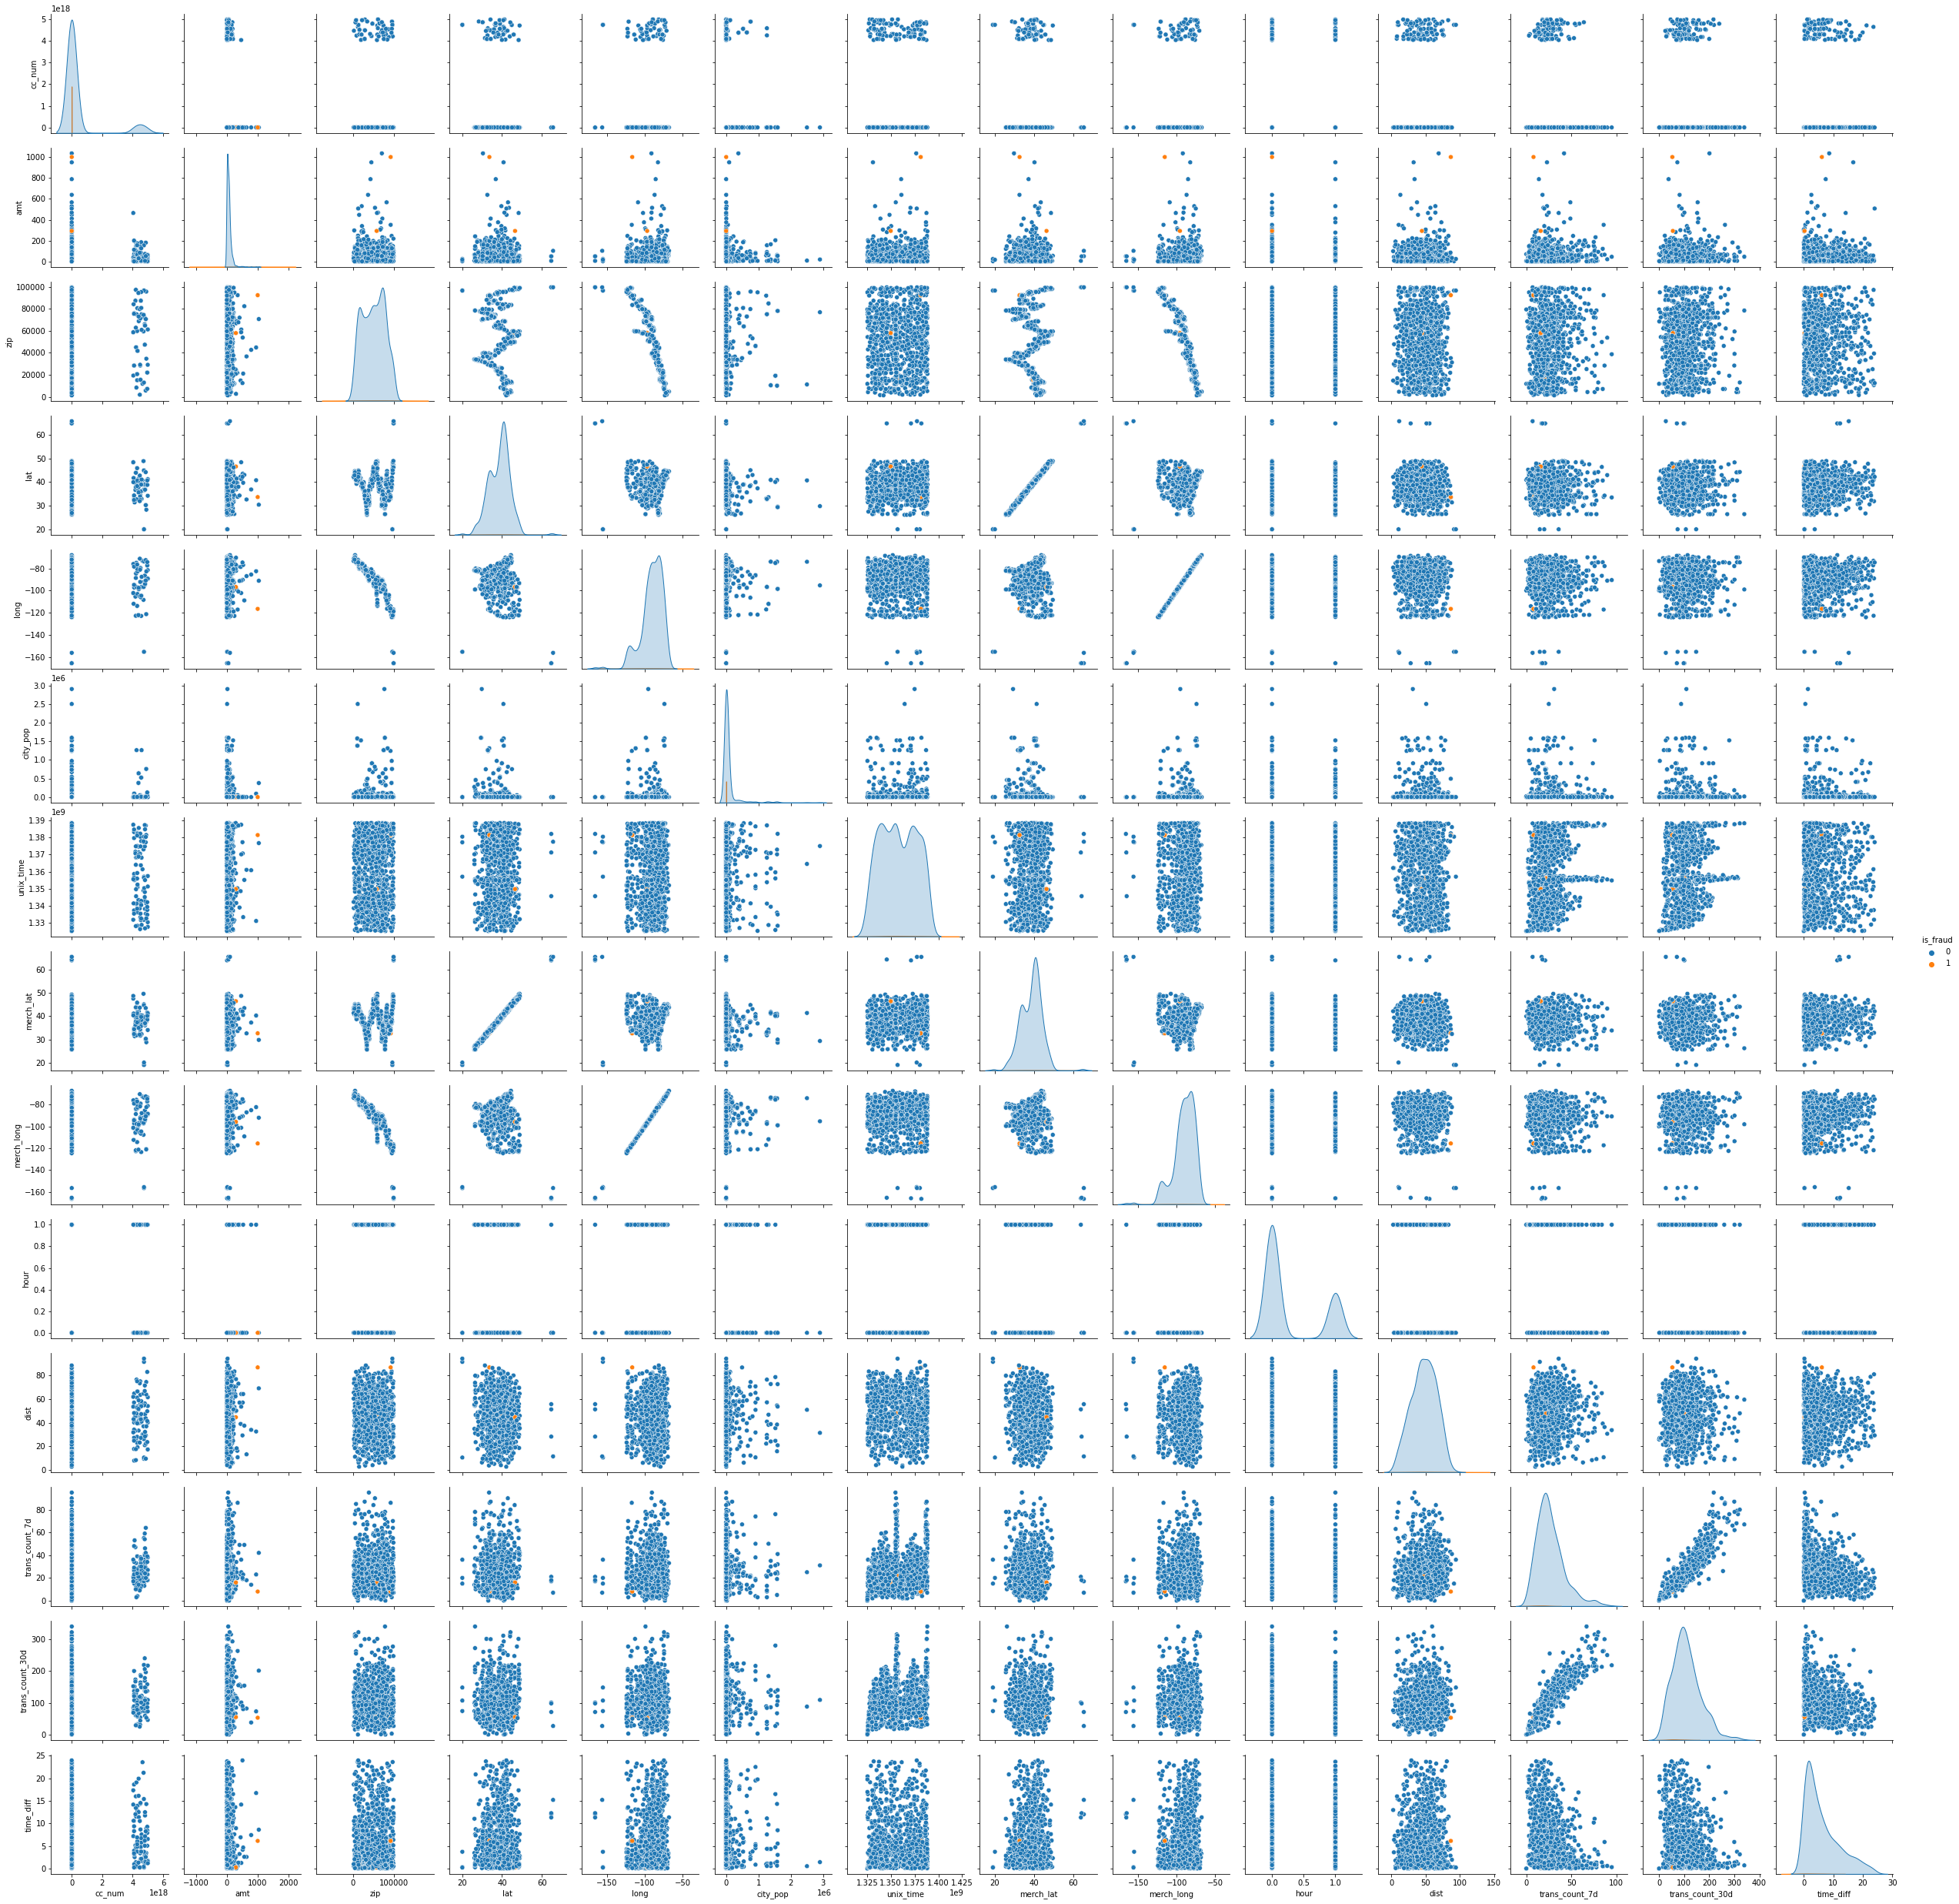

In [25]:
# pairplot for all samples takes too long, take a random sample of 1000 rows
sns.pairplot(df.sample(1000), hue = 'is_fraud')

is_fraud           1.000000
amt                0.209308
hour               0.052954
trans_count_30d    0.044932
trans_count_7d     0.035326
time_diff          0.014862
unix_time          0.013329
lat                0.002904
merch_lat          0.002778
zip                0.002190
cc_num             0.001125
long               0.001022
merch_long         0.000999
dist               0.000362
city_pop           0.000325
Name: is_fraud, dtype: float64

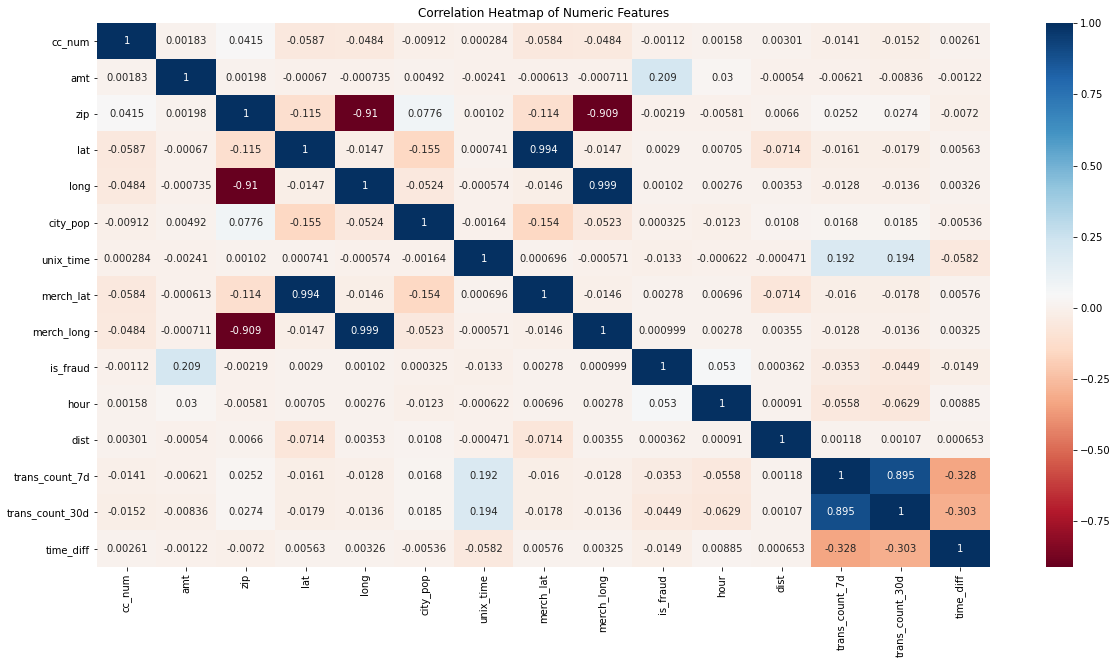

In [26]:
# correlation matrix with only numeric variables
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df.corr(), annot = True, cmap = 'RdBu', fmt = '.3g').set_title('Correlation Heatmap of Numeric Features')
df.corr()['is_fraud'].abs().sort_values(ascending = False)

is_fraud           1.000000
amt                0.209308
hour               0.052954
trans_count_30d    0.044932
trans_count_7d     0.035326
category           0.019278
time_diff          0.014862
unix_time          0.013329
gender             0.005844
lat                0.002904
merch_lat          0.002778
zip                0.002190
job                0.001388
cc_num             0.001125
city               0.001107
long               0.001022
merch_long         0.000999
merchant           0.000424
dist               0.000362
city_pop           0.000325
state              0.000252
Name: is_fraud, dtype: float64

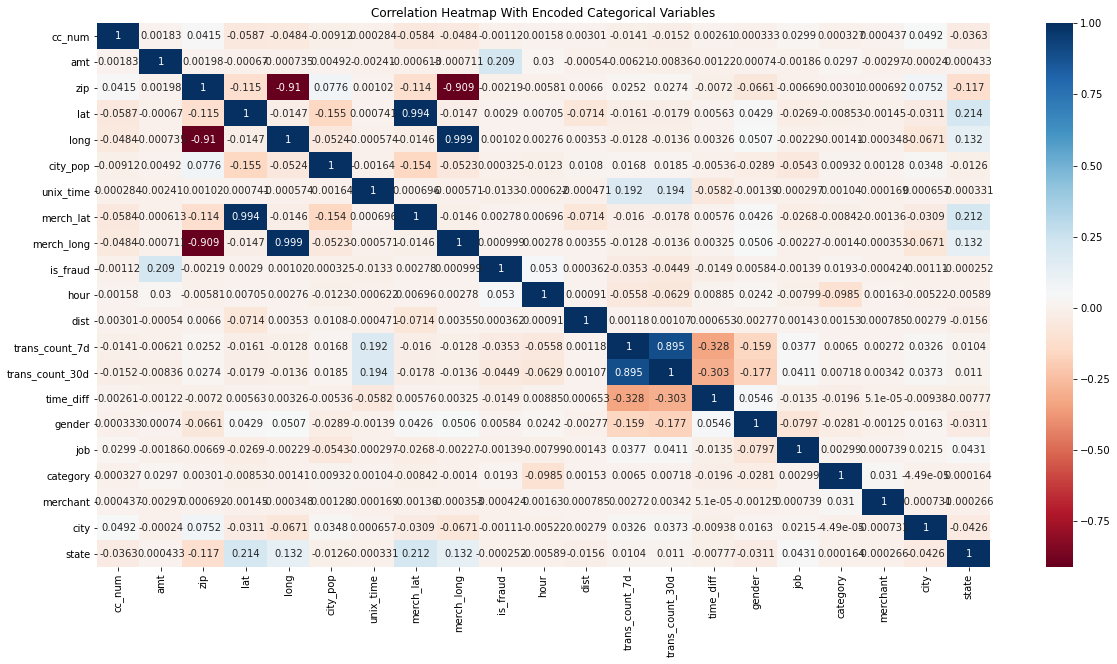

In [27]:
# correlation matrix with label encoded categorical variables
df_label = pd.concat([df, gender_label, job_label, category_label, merchant_label, city_label, state_label], axis = 1)

fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df_label.corr(), annot = True, cmap = 'RdBu', fmt = '.3g').set_title('Correlation Heatmap With Encoded Categorical Variables')
df_label.corr()['is_fraud'].abs().sort_values(ascending = False)

<AxesSubplot:>

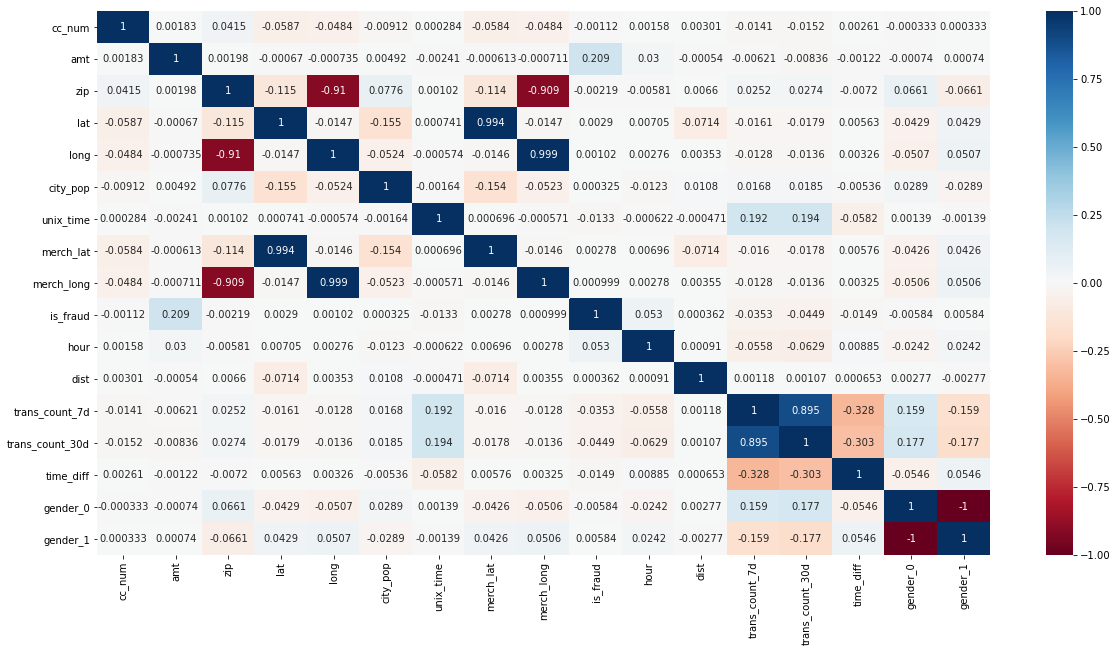

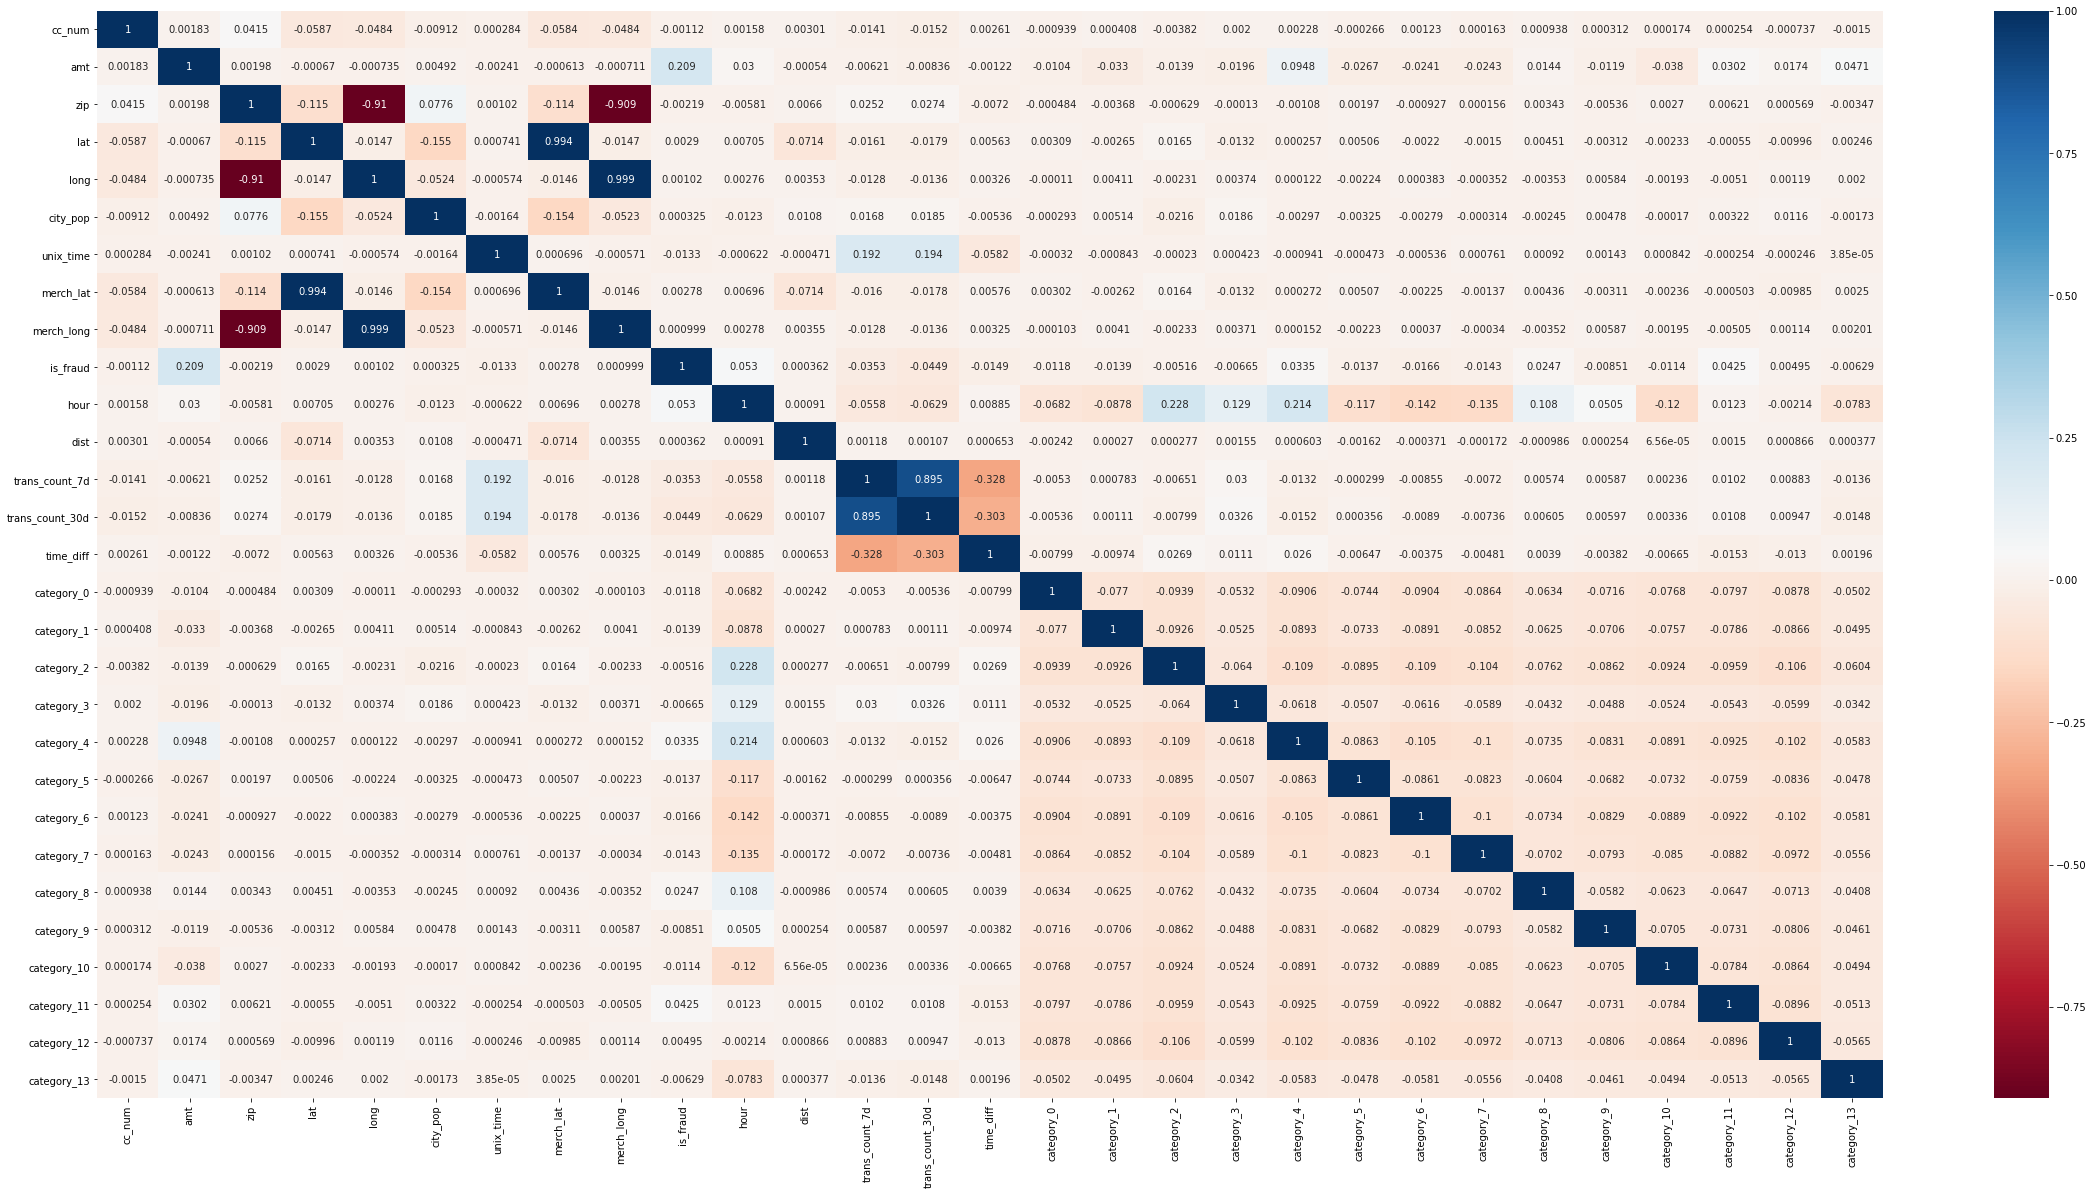

In [28]:
# didn't plot the heatmaps for the other encoded variables as they had too many unique values
# correlation matrix with one hot encoded gender
df_gender_onehot = pd.concat([df, gender_onehot], axis = 1)
fig, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(df_gender_onehot.corr(), annot = True, cmap = 'RdBu', fmt = '.3g')

# correlation matrix with one hot encoded category
df_category_onehot = pd.concat([df, category_onehot], axis = 1)
fig, ax = plt.subplots(figsize = (40, 20))
sns.heatmap(df_category_onehot.corr(), annot = True, cmap = 'RdBu', fmt = '.3g')

From the correlation heatmaps above, we can see that the attributes that are most correlated with the independent variable `is_fraud` are:
- Transaction Amount (`amt`)
- Hour Transaction Was Made (`hour`)
- Number of Transactions Within the Last 30 Days (`trans_count_30d`)
- Number of Transactions Within the Last 7 Days (`trans_count_7d`)
- Type of Transaction (`category`)
- Time Since Last Transaction (`time_diff`)

**Feature Selection**

In [29]:
# drop unnecessary columns, features with correlation < 0.01
df.drop(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'dist'], axis = 1, inplace = True)
# add one hot encoded category attribute
df = pd.concat([df, category_onehot], axis = 1)
print(df.shape)

(1852394, 20)


In [30]:
df.head()

amt  is_fraud  hour  trans_count_7d  trans_count_30d  time_diff  \
0    4.97         0     1             0.0              0.0        0.0   
1  107.23         0     1             0.0              0.0        0.0   
2  220.11         0     1             0.0              0.0        0.0   
3   45.00         0     1             0.0              0.0        0.0   
4   41.96         0     1             0.0              0.0        0.0   

   category_0  category_1  category_2  category_3  category_4  category_5  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         1.0         0.0   
2         1.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         1.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   category_6  category_7  category_8  category_9  category_10  category_11  \
0         0.0         0.0         1.0         0.0          0.0          0.0   
1         0.0         0.0         0.0         0.0          0.0          0.0   
2         0.0         0.0         0.0         0.0          0.0          0.0   
3         0.0         0.0         0.0         0.0          0.0          0.0   
4         0.0         0.0         0.0         1.0          0.0          0.0   

   category_12  category_13  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0

Dropped columns: 
- Row Index (`index`)
- Transaction Date and Time (`trans_date_trans_time`)
- Credit Card Number (`cc_num`)
- Merchant (`merchant`)
- First Name (`first`)
- Last Name (`last`)
- Gender (`gender`)
- Street (`street`)
- City (`city`)
- State (`state`)
- Zip (`zip`)
- Latitude (`lat`)
- Longitude (`long`)
- City Population (`city_pop`)
- Job (`job`)
- Date of Birth (`dob`)
- Transaction Number (`trans_num`)
- Unix Time (`unix_time`)
- Merchant Latitude (`merch_lat`)
- Merchant Longitude (`merch_long`)
- Distance (`dist`)

**Feature Scaling**

In [31]:
# min-max normalization

scaler = MinMaxScaler()
df_y_removed = df.drop(columns = ['is_fraud'])
scaled = scaler.fit_transform(df_y_removed)
df_minmax = pd.DataFrame(scaled, columns = ['amt', 'hour', 'trans_count_7d', 'trans_count_30d', 'time_diff', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13'])
# add is_fraud column back into data set
df_minmax['is_fraud'] = df['is_fraud']

In [32]:
# standardization

scaler = StandardScaler()
scaled = scaler.fit_transform(df_y_removed)
df_standardized = pd.DataFrame(scaled, columns = ['amt', 'hour', 'trans_count_7d', 'trans_count_30d', 'time_diff', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13'])
# add is_fraud column back into data set
df_standardized['is_fraud'] = df['is_fraud']

Since we don't know what model(s) we want to use yet, we normalized and standardized the data.

**Split Data**

In [33]:
# split original data that has not been normalized or standardized
train, test = train_test_split(df, test_size = 0.2, random_state = 12)
X_train, y_train = train.drop(columns = ['is_fraud']), train['is_fraud']
X_test, y_test = test.drop(columns = ['is_fraud']), test['is_fraud']

In [34]:
# split normalized data
train, test = train_test_split(df_minmax, test_size = 0.2, random_state = 12)
X_train, y_train = train.drop(columns = ['is_fraud']), train['is_fraud']
X_test, y_test = test.drop(columns = ['is_fraud']), test['is_fraud']

In [35]:
# split standardized data
train, test = train_test_split(df_standardized, test_size = 0.2, random_state = 12)
X_train, y_train = train.drop(columns = ['is_fraud']), train['is_fraud']
X_test, y_test = test.drop(columns = ['is_fraud']), test['is_fraud']

**Dealing With Imbalanced Data**

In [36]:
# undersampling (using training set)
# can lead to loss of useful information

rus = RandomUnderSampler(random_state = 42, replacement = True)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print('Original Dataset Shape:', Counter(y_train))
print('Resampled (Under) Dataset Shape', Counter(y_train_rus))

# oversampling (using training set)
# can lead to overfitting

smote = SMOTE()

# fit predictor and target variable
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('Original Dataset Shape', Counter(y_train))
print('Resample (Over) Dataset Shape', Counter(y_train_smote))

Original Dataset Shape: Counter({0: 1474173, 1: 7742})
Resampled (Under) Dataset Shape Counter({0: 7742, 1: 7742})
Original Dataset Shape Counter({0: 1474173, 1: 7742})
Resample (Over) Dataset Shape Counter({0: 1474173, 1: 1474173})
